# K-Nearest Neighbours

K-Nearest Neighbours is a supervised machine learning method used for classification problems. 

In the most basic case where we have two features to predict a single categorical outcome, we can plot the two features on a set of x and y-axes. We can add a color layer for each plotted point which indicates the categorical class outcome that the point belongs to. From there, we can plot the points for which we have unknown categorical outcomes. Then we look at the K nearest neighbors to that unknown point, and the most popular neighbor is the class that we will assign the unknown point. 

In [32]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from statistics import stdev

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 1. Load in and explore data

In [2]:
data_path = 'https://raw.githubusercontent.com/YaminiMuralidharen/MachineLearningexercises/master/teleCust1000t.csv'
data = pd.read_csv(data_path)

In [3]:
data['custcat'].value_counts().sort_index()

1    266
2    217
3    281
4    236
Name: custcat, dtype: int64

<AxesSubplot:>

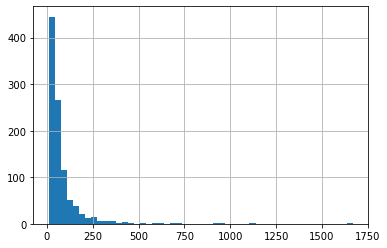

In [4]:
data['income'].hist(bins=50)

### 2. Define the Feature Set

First we'll need to retrieve all our features columns and turn them into a numpy array

In [5]:
X = data[[col for col in data.columns if col != 'custcat']].values # By accessing the values we turn our data frame object into an array object
X[0:5] # return the first five rows of our array

array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

Next we define our label set.

In [6]:
txt = (f'Subsetting a data frame with a single bracket returns a {type(data["custcat"])} \n'
       f'Subsetting a data frame with double brackets returns a {type(data[["custcat"]])} \n'
       f'Subsetting a data frame with the values method returns a {type(data[["custcat"]].values)}'
      )
print(txt)


Subsetting a data frame with a single bracket returns a <class 'pandas.core.series.Series'> 
Subsetting a data frame with double brackets returns a <class 'pandas.core.frame.DataFrame'> 
Subsetting a data frame with the values method returns a <class 'numpy.ndarray'>


In [7]:
y = data.custcat.values
y[0:5]

array([1, 4, 3, 1, 3])

### 3. Normalize the Data

Machine learning algorithms generally perform better or converge faster when features are on a relatively similar scale and are close to a normal distribution. `StandardScaler` is the industry's go-to. 

This algorithm does: 
1. Subtracts the mean from each observation
2. Scales to unit variance - or divides by the standard deviation

This algorithm results in: 
1. Standard deviation equal to 1
2. Variance also equal to 1 because variance is the standard deviation squared
3. Mean distribution of 0

In [8]:
result = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

Check the resulting standardized array against the original array object named X.

In [9]:
print(f'The mean of the scaled array is {np.round(np.mean(result), 2)})')
print(f'The mean of the original array is {np.round(np.mean(X), 2)}')

print('\n')

print(f'The standard deviation of the scaled array is {np.round(stdev(result.tolist()[0]), 0)}')
print(f'The standard deviation of the original array is {np.round(stdev(X.tolist()[0]), 0)}')

The mean of the scaled array is 0.0)
The mean of the original array is 16.85


The standard deviation of the scaled array is 1.0
The standard deviation of the original array is 21.0


However, it is important to note that while the values of each individual observation have changed (resulting in a new distribution), the shape of the array has not.

In [10]:
print(result.shape, '\n', X.shape)

(1000, 11) 
 (1000, 11)


By plotting the resulting arrays we can also visualize the new distributions. The scaled values clearly have a mean that is approximately zero and the shape of the distrbution closely resembles a normal distribution. On a programming note, we'll need to access `numpy`'s `tolist()` method in order to turn an array into a list.

<AxesSubplot:xlabel='value', ylabel='Density'>

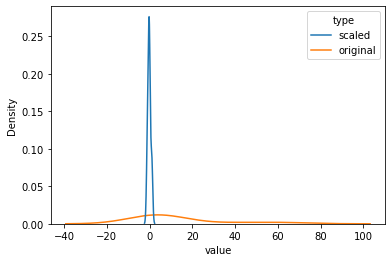

In [18]:
scaledvals_df = pd.DataFrame({'value':result.tolist()[0], 'type':'scaled'})
originalvals_df = pd.DataFrame({'value':X.tolist()[0], 'type':'original'})

plotting_df = pd.concat([scaledvals_df, originalvals_df]).reset_index(drop=True)

sns.kdeplot(data=plotting_df, x='value', hue='type')

### 4. Train Test Split

Now that we understand what the data look like, we will split the data into training and testing splits. For the sake of organization, we will redefine the object X to be the scaled and transformed values after using `StandardScaler`, instead of using the object named `result`. This will make it easier to keep track of objects in the environment.

In [19]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.02696767, -1.055125  ,  0.18450456,  1.0100505 , -0.25303431,
        -0.12650641,  1.0877526 , -0.5941226 , -0.22207644, -1.03459817,
        -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243,  1.0100505 , -0.4514148 ,
         0.54644972,  1.9062271 , -0.5941226 , -0.22207644, -1.03459817,
         2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601,  1.0100505 ,  1.23481934,
         0.35951747, -1.36767088,  1.78752803, -0.22207644,  0.96655883,
        -0.23065004],
       [-0.02696767, -0.11831864, -0.69181243, -0.9900495 ,  0.04453642,
        -0.41625141, -0.54919639, -1.09029981, -0.22207644,  0.96655883,
        -0.92747794],
       [-0.02696767, -0.58672182, -0.93080797,  1.0100505 , -0.25303431,
        -0.44429125, -1.36767088, -0.89182893, -0.22207644, -1.03459817,
         1.16300577]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(800, 11) (800,) (200, 11) (200,)


### 5. Training the model
For K Nearest Neighbours we have to specify the paramter K. In this initial example, we'll use K=4. With K=4, we'll look at the four nearest neighbors to each unknown point and then classify that neighbor to be the same as the most common class of the four nearest neighbors. 

In [21]:
k = 4
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

### 6. Prediction

Now that we've trained the model on our training data sets, we can make predictions.

In [23]:
predicted_y_classes = knn.predict(X_test)

### 7. Accuracy Evaluation

Now that we have predicted the predicted classes based on the algorithm, we can test to see how accurate our model was by comparing the predicted classes against the actual classes in `y_test`.

We can manually compare the number of matches (`True` values) there are and divide that by the total number of values in our testing set. 

In [26]:
sum(predicted_y_classes == y_test) / len(predicted_y_classes)

0.27

In [25]:
print(f'The training accuracy is {metrics.accuracy_score(y_train, knn.predict(X_train))}')
print(f'The testing accuracy is {metrics.accuracy_score(y_test, predicted_y_classes)}')

The training accuracy is 0.565
The testing accuracy is 0.27


We can also calculate the F1 score which takes into account precision and recall. The F1 score is its best when it has a value of 1 and at its worst when at a value of 0. Its formula is:

F1 = 2 * (precision * recall) / (precision + recall)

In [78]:
f1_score(y_true=y_test, y_pred=predicted_y_classes, average=None)

array([0.37209302, 0.175     , 0.28571429, 0.16666667])

We can also derive this score manually using the formula above.

#### 7a. Confusion Matrix

We can create a confusion matrix which shows the true values on one axis and the predicted values on the other axis.

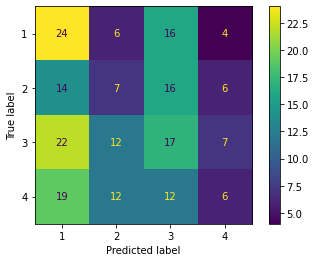

In [62]:
cm = confusion_matrix(y_true=y_test, y_pred=predicted_y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[num for num in range(1, 5)])
disp.plot()
plt.show()

In the very first cell in the top left corner, there are 24 instances where the true class is 1 and the predicted class is 1. In the cell directly to the right, there are 6 instances where the true value is 1, but our model predicted the value to be 2. 

#### 7b. Precision

Precision is claulated as the ratio of true positives (classes classifed correctly) to the sum of true positives and false positives (tp / (tp + fp)). The sum of fp + fp can be seen in the columns of the confusion matrix. Intuitively, it's the ability of the classifier not to label negative as a positive. Of all the positive identifications, how many were actually correct? This is the ability to find all the positives.

In [97]:
print(cm[0, 0] / sum(cm[:, 0]),
     cm[1, 1] / sum(cm[:, 1]),
     cm[2, 2] / sum(cm[:, 2]),
     cm[3, 3] / sum(cm[:, 3])
     )

0.3037974683544304 0.1891891891891892 0.2786885245901639 0.2608695652173913


The first value can be interpreted as follows - when it predicts a class of 1, it is correct roughly 31% of the time. We don't need to calculate this by hand all the time, as we can turn to `sklearn`'s precision score to compute it for us. 

In [99]:
precision_score(y_true=y_test, y_pred=predicted_y_classes, average=None)

array([0.30379747, 0.18918919, 0.27868852, 0.26086957])

We can see that `sklearn`'s `precision_score` function returns the same values that we had manually calculated ourselves. Note that in the above example, it returns an array of length four, a precision score for each possible class in our data. However, it can also return one aggregated value by specifying a different value for the `average` argument.

In [110]:
precision_score(y_true=y_test, y_pred=predicted_y_classes, average='macro')

0.2581361868377937

In the above line of code, we specify `macro` into the `average` argument, which is identical to finding the unweighted average of all the precision scores for each one of the possible classes. We can see that in the below:

In [113]:
np.mean(precision_score(y_true=y_test, y_pred=predicted_y_classes, average=None).tolist())

0.2581361868377937

#### 7c. Recall

Recall is the ratio of true positives to the sum of true positives and false negatives. Mathematically *tp / (tp + fn)*. 

Intuitively, we can think of recall as the classifier's ability to find all the positive samples. In other words, what proportion of actual positives was identified correctly. 

In [128]:
cm[0, 0] / sum(cm[0])
cm[1, 1] / sum(cm[1])
cm[2, 2] / sum(cm[2])
cm[3, 3] / sum(cm[3])

0.12244897959183673

In [118]:
recall_score(y_true=y_test, y_pred=predicted_y_classes, average=None)

array([0.48      , 0.1627907 , 0.29310345, 0.12244898])

Recall is particularly helpful when our data is unbalanced in one direction. For example, in the binary case, it's possible that the frequency of negatives greatly outnumbers the frequency of positives (terrorist). In reality, very few flyers are terrorists. If our imaginary classifying model arbitrarily labels everyone as not a terrorist, it would be incredibly accurate! Recall says the model correctly identifies xx% of all terrorists. On the other hand, precision says, when the model predicts a terrorist, it is right xx% of the time.

### 8. Other Values of K

K is a value specified by the user. But how do we specify the "right" k? If we choose too little K, this can result in poor out of sample accuracy because there may not be enough number of neighbors. Any outliers may mislead the classification. Alternatively, if we choose too many K, then we may have trained our model too well on the training data and it will perform poorly on out of sample data.

In [114]:
Ks = 10

accuracy_scores = []
for k in range(1, Ks): 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_hat = knn.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_hat)
    accuracy_scores.append(accuracy)

<AxesSubplot:xlabel='Ks', ylabel='AccuracyScores'>

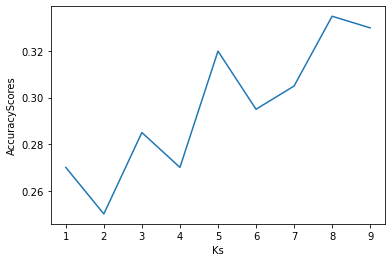

In [115]:
accuracy_df = pd.DataFrame({'Ks': [k for k in range(1, Ks)], 'AccuracyScores': accuracy_scores})
sns.lineplot(data=accuracy_df, x='Ks', y='AccuracyScores')

In [116]:
optimal_values = accuracy_df[accuracy_df['AccuracyScores'] == max(accuracy_df['AccuracyScores'])]

In [117]:
print(f'The optimal number of neighbors is {optimal_values.Ks.values[0]} which is associated with an accuracy score of {optimal_values.AccuracyScores.values[0]}.')

The optimal number of neighbors is 8 which is associated with an accuracy score of 0.335.
